<a href="https://colab.research.google.com/github/benson85560/yuanta/blob/main/Dividend_Yield_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time
from pandas.core.tools.datetimes import to_datetime


path = os.getcwd()
print(path)

/content


In [2]:
!pip install yfinance
import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [3]:
#Colab安裝Talib
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

--2022-08-04 23:57:06--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-08-04 23:57:06--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://cytranet.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-08-04 23:57:06--  http://cytranet.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving cytranet.dl.s

In [153]:
import talib 
from talib import abstract

#Main Strategy : 息收前後進場
1. 除息日前 x 天進場，前 y 天出場
2. 除昔日後 z 天進場，(等回補出場)



## for single symbol

---loading: 0050.TW---
             0050.TW
2008-01-02  0.000000
2008-01-03  0.000000
2008-01-04  0.000000
2008-01-07  0.000000
2008-01-08  0.000000
...              ...
2022-06-22  9.682142
2022-06-23  9.682142
2022-06-24  9.682142
2022-06-27  9.682142
2022-06-28  9.682142

[3574 rows x 1 columns]


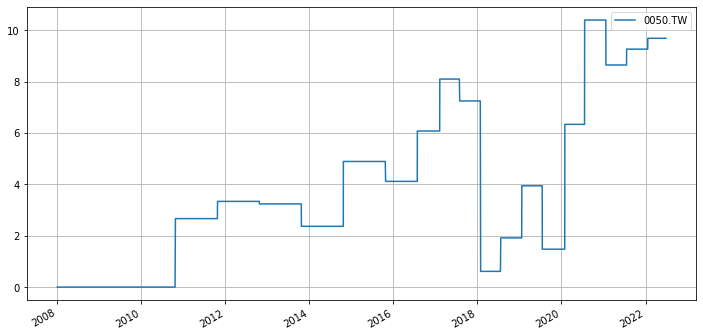

In [171]:
# 主要策略

symbol = '0050.TW'
data = yf.Ticker(symbol)
df = data.history(period='D', start='2008-1-1', end='2022-6-30')
df = df.drop(columns = ['Dividends', 'Stock Splits'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
Yield = pd.read_csv(path + '/yield.csv')
Yield = Yield.set_index(pd.to_datetime(Yield['date']))
Yield = Yield.drop('date', axis = 1)
df = pd.concat([df,Yield], join='outer', axis=1)

# initial setting

fund = 100 #初始有100元本金
money = 100 #每次投入
feeRate = 0.003 #手續費

# 主要策略

profit_list = []
price = []
buy = []
sell = []
open_price = []
timeList = []

print(f'---loading: {symbol}---')

for i in range(len(df)):

    if i == len(df)-1:
      break
    
    # if df['0050'][i] > 0 and df['close'][i] > 0 : # 除息日
    #     tempSize = money / df['close'][i-30] # 前 15 天進場
    #     buy.append(i-30)
  
    #     profit = tempSize * (df['close'][i-5] - df['close'][i-30]) # 前 5 天出場並計算報酬
    #     sell.append(i-5)
    #     profit_list.append(profit)
    #     timeList.append(df.index[i]) 
        
        

    if df['0050'][i] > 0 and df['close'][i] > 0: # 除息日
        tempSize = money / df['open'][i+1] # 後 1 天進場
        buy.append(i+1)
  
        profit = tempSize * (df['open'][i+10] - df['open'][i+1]) # 後 20 天出場並計算報酬
        sell.append(i+10)
        profit_list.append(profit)
        timeList.append(df.index[i]) 



    else:
      profit_list.append(0)
      timeList.append(df.index[i])

equity = pd.DataFrame({'0050.TW':np.cumsum(profit_list)}, index=timeList)
print(equity)
equity.plot(grid=True, figsize=(12, 6));

In [163]:
# 實際交易位置
print(buy)
print(sell)
# print(buy2)
# print(sell2)

[700, 949, 1199, 1445, 1693, 1940, 2126, 2256, 2374, 2501, 2615, 2743, 2858, 2985, 3101, 3230, 3346, 3474]
[709, 958, 1208, 1454, 1702, 1949, 2135, 2265, 2383, 2510, 2624, 2752, 2867, 2994, 3110, 3239, 3355, 3483]


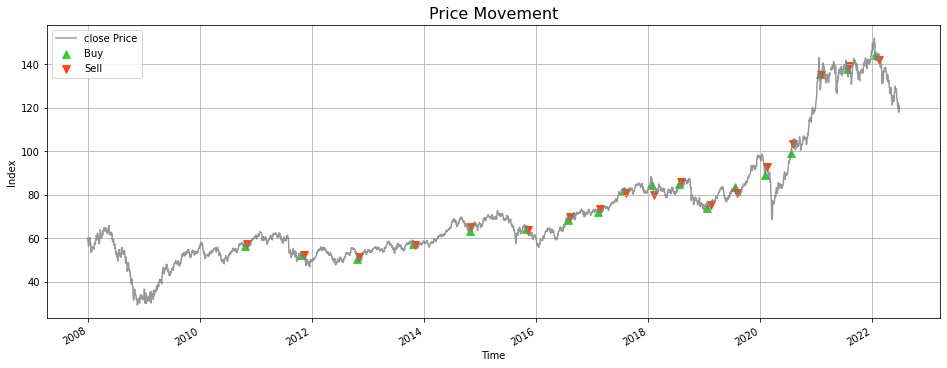

In [164]:
fig, ax = plt.subplots(figsize = (16,6))

df['close'].plot(label = 'close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(df['close'].iloc[buy].index, df['close'].iloc[buy],c = 'limegreen', label = 'Buy', marker='^', s=60)
plt.scatter(df['close'].iloc[sell].index, df['close'].iloc[sell],c = 'orangered', label = 'Sell', marker='v', s=60)
# plt.scatter(df['close'].iloc[buy2].index, df['close'].iloc[buy2],c = 'y', label = 'Buy2', marker='^', s=60)
# plt.scatter(df['close'].iloc[sell2].index, df['close'].iloc[sell2],c = 'b', label = 'Sell2', marker='v', s=60)

plt.legend()
plt.ylabel('Index')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16);

In [ ]:
equity['equity'] = equity['profit'] + fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()

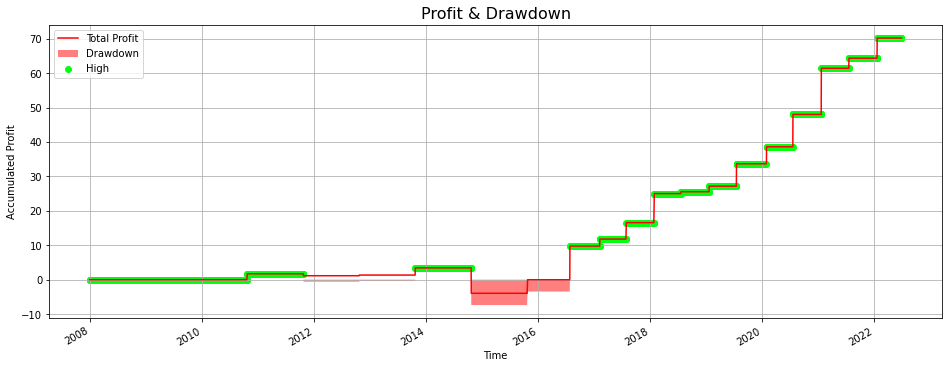

In [ ]:
fig, ax = plt.subplots(figsize = (16,6))

high_index = equity[equity['profit'].cummax() == equity['profit']].index
equity['profit'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['profit'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);

# 成網格狀是因為一次加總多天報酬

## for all

In [177]:
symbol = '0050.TW'
data = yf.Ticker(symbol)
df = data.history(period='D', start='2008-1-1', end='2022-6-30')
df = df.drop(columns = ['Dividends', 'Stock Splits'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
Yield = pd.read_csv(path + '/yield.csv')
Yield = Yield.set_index(pd.to_datetime(Yield['date']))
Yield = Yield.drop('date', axis = 1)
df = pd.concat([df,Yield], join='outer', axis=1)

# initial setting

fund = 100 #初始有100元本金
money = 100 #每次投入
feeRate = 0.003 #手續費

# 主要策略

profit_list = []
price = []
buy = []
sell = []
open_price = []
position = "A"
timeList = []

print(f'---loading: {symbol}---')

for i in range(len(df)):

    if i == len(df)-1:
      break
    
    # if df['0050'][i] > 0 and df['close'][i] > 0: # 除息日
    #     tempSize = money / df['close'][i-30] # 前 15 天進場
    #     buy.append(i-30)
  
    #     profit = tempSize * (df['close'][i-5] - df['close'][i-30]) # 前 5 天出場並計算報酬
    #     sell.append(i-5)
    #     profit_list.append(profit)
    #     timeList.append(df.index[i]) 

    if df['0050'][i] > 0 and df['close'][i] > 0: # 除息日
        tempSize = money / df['open'][i+1] # 後 1 天進場
        buy.append(i+1)
  
        profit = tempSize * (df['open'][i+20] - df['open'][i+1]) # 後 20 天出場並計算報酬
        sell.append(i+20)
        profit_list.append(profit)
        timeList.append(df.index[i]) 

    else:
      profit_list.append(0)
      timeList.append(df.index[i])

equity = pd.DataFrame({'0050.TW':np.cumsum(profit_list)}, index=timeList)
  
########-------------------------------------------------------------#########

symbol_list = ['0051.TW', '0052.TW', '0053.TW', '0055.TW', '0056.TW', '006203.TW', '006204.TW', '006208.TW', 
               '00690.TW', '00692.TW', '00701.TW', '00712.TW', '00713.TW', '00714.TW', '00717.TW',
               '00728.TW', '00730.TW', '00731.TW', '00733.TW', '00735.TW']

for j in range(len(symbol_list)):
  symbol = symbol_list[j]

  print(f'---loading: {symbol}---')

  data = yf.Ticker(symbol)
  df = data.history(period='D', start='2008-1-1', end='2022-6-30')
  df = df.drop(columns = ['Dividends', 'Stock Splits'])
  df.columns = ['open', 'high', 'low', 'close', 'volume']
  Yield = pd.read_csv(path + '/yield.csv')
  Yield = Yield.set_index(pd.to_datetime(Yield['date']))
  Yield = Yield.drop('date', axis = 1)
  df = pd.concat([df,Yield], join='outer', axis=1)

  # initial setting

  fund = 100 #初始有100元本金
  money = 100 #每次投入
  feeRate = 0.003 #手續費

  # 主要策略

  profit_list = []
  price = []
  buy = []
  sell = []
  open_price = []
  position = "A"
  timeList = []

  for i in range(len(df)):

      if i == len(df)-1:
        break
      
      # if df['0050'][i] > 0 and df['close'][i] > 0: # 除息日 => 每標的:df.iloc[:,j+6][i]
      #     tempSize = money / df['close'][i-30] # 前 15 天進場
      #     buy.append(i-30)
    
      #     profit = tempSize * (df['close'][i-5] - df['close'][i-30]) # 前 5 天出場並計算報酬
      #     sell.append(i-5)
      #     profit_list.append(profit)
      #     timeList.append(df.index[i]) 
      if df.iloc[:,j+6][i] > 0 and df['close'][i] > 0: # 除息日
          tempSize = money / df['open'][i+1] # 後 1 天進場
          buy.append(i+1)
    
          profit = tempSize * (df['open'][i+20] - df['open'][i+1]) # 後 20 天出場並計算報酬
          sell.append(i+20)
          profit_list.append(profit)
          timeList.append(df.index[i]) 

      else:
        profit_list.append(0)
        timeList.append(df.index[i])

  pp = pd.DataFrame({'{}'.format(symbol_list[j]):np.cumsum(profit_list)}, index=timeList)
  equity = pd.concat([equity,pp], join='outer', axis=1)

equity

---loading: 0050.TW---
---loading: 0051.TW---
---loading: 0052.TW---
---loading: 0053.TW---
---loading: 0055.TW---
---loading: 0056.TW---
---loading: 006203.TW---
---loading: 006204.TW---
---loading: 006208.TW---
---loading: 00690.TW---
---loading: 00692.TW---
---loading: 00701.TW---
---loading: 00712.TW---
---loading: 00713.TW---
---loading: 00714.TW---
---loading: 00717.TW---
---loading: 00728.TW---
---loading: 00730.TW---
---loading: 00731.TW---
---loading: 00733.TW---
---loading: 00735.TW---


,0050.TW,0051.TW,0052.TW,0053.TW,0055.TW,0056.TW,006203.TW,006204.TW,006208.TW,00690.TW,...,00701.TW,00712.TW,00713.TW,00714.TW,00717.TW,00728.TW,00730.TW,00731.TW,00733.TW,00735.TW
2008-01-02,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-03,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-04,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-07,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-08,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-22,-7.73352,20.014512,-24.888536,16.264421,8.827147,-4.708208,4.505587,11.497685,9.51766,6.55899,...,9.961143,8.91695,-1.057728,14.403109,-6.790658,3.003854,7.154008,NaN,-4.754989,-1.670439
2022-06-23,-7.73352,20.014512,-24.888536,16.264421,8.827147,-4.708208,4.505587,11.497685,9.51766,6.55899,...,9.961143,8.91695,-1.057728,14.403109,-6.790658,3.003854,7.154008,NaN,-4.754989,-1.670439
2022-06-24,-7.73352,20.014512,-24.888536,16.264421,8.827147,-4.708208,4.505587,11.497685,9.51766,6.55899,...,9.961143,8.91695,-1.057728,14.403109,-6.790658,3.003854,7.154008,NaN,-4.754989,-1.670439
2022-06-27,-7.73352,20.014512,-24.888536,16.264421,8.827147,-4.708208,4.505587,11.497685,9.51766,6.55899,...,9.961143,8.91695,-1.057728,14.403109,-6.790658,3.003854,7.154008,NaN,-4.754989,-1.670439


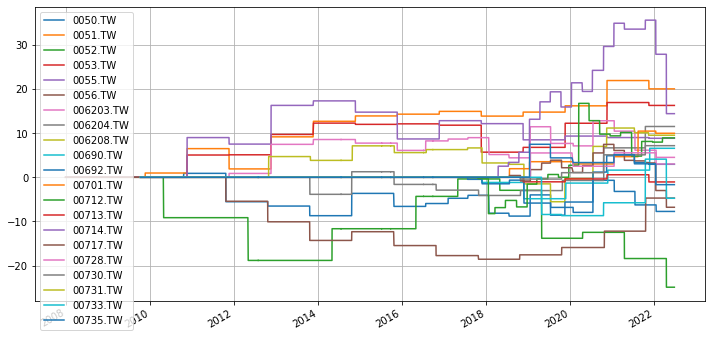

In [178]:
equity.plot(grid=True, figsize=(12, 6));

In [176]:
equity.iloc[-1].mean() # 息收後

3.4305208404929544

In [149]:
d1 = equity.iloc[-1].mean()
d1　# 息收前（all）

14.302135379208972

In [152]:
d2 = equity.iloc[-1].mean()
d2 # 息收前（0050）

37.13192644512107

In [175]:
print(d1, d2)

14.302135379208972 37.13192644512107


# Sub strategy : 順勢策略
1. EMA : df['Close'] > EMA(200)
2. MACD : MACD > 0
3. SAR : SAR < df['Close'] 

* 停損 : stopLoss = df['Close'][i] - SAR[i]
* 停利 : = stopLoss

## for single model

In [208]:
# 新策略
symbol = '0052.TW'
print(f'---loading: {symbol}---')
data = yf.Ticker(symbol)
df = data.history(period='D', start='2008-1-1', end='2022-6-30')
df = df.drop(columns = ['Dividends', 'Stock Splits'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['EMA'] = abstract.EMA(df, timeperiod = 200)
df['MACD'] = abstract.MACD(df, fastperiod=12, slowperiod=26, signalperiod=9)['macd']
df['SAR'] = abstract.SAR(df)

fund = 100 #初始有100元本金
money = 100 #每次投入100元
feeRate = 0.003
length = 40 # 均線長度
stdTimes = 2 # 標準差倍數
rule = '1H' # hour


first = 0 ##除了第一筆之外，只紀錄出場的時間點
BS = None ##紀錄現在的狀態是做多還做空
stopEarn = 0
stopLoss = 0

#--------# 記錄買入、賣出時間點
buy = []
sell_win = []
sell_lose = []
sellshort = []
buytocover = []
# stopLoss = []
#--------# 
timeList = [] 
profit_list = [0]
profit_fee_list = [0]


for i in range(len(df)):

    if i == len(df)-1: # last trading day
        break
     
      # buy                                       # BS: position, B: buy, S: sell
    if df['close'][i] > df['EMA'][i] and df['MACD'][i] > 0 and df['close'][i] > df['SAR'][i] and BS == None:
        temp = df['open'][i+1] # 要加一 當看到訊號後的進場價
        tempSize = money / temp # 計算交易單位
        BS = 'B' # 做多
        t = i+1 
        buy.append(t)
        stopLoss = df['SAR'][i]
        stopEarn = df['close'][i] + ((df['close'][i] - df['SAR'][i]) * 2)
        # stopLoss.append(df['close'][i] - df['SAR'][i])

        
        if first == 0:
            timeList.append(df.index[i+1])
            first = 1
        continue

      # try 'buy' first 
      # sellshort
    # if df['close'][i] < df['EMA'][i] and df['MACD'][i] < 0 and df['close'][i] < df['SAR'][i] and BS == None:
    #     temp = df['open'][i+1]
    #     tempSize = money / temp
    #     BS = 'S'
    #     t = i+1
    #     sellshort.append(t)
        

    #     if first == 0:
    #         timeList.append(df.index[i+1])
    #         first = 1
    #     continue
        
      # buy停利
    if df['close'][i] > stopEarn and BS == 'B':
        profit = tempSize * (df['open'][i+1] - temp) # temp : 進場價
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell_win.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue

      # buy停損
    if df['close'][i] < stopLoss and BS == 'B':
        profit = tempSize * (df['open'][i+1] - temp) # temp : 進場價
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell_lose.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue

       # buy to cover
    # if (df['close'][i] >= df['ma'][i] or i == len(df)-2) and BS == 'S':
    #     profit = tempSize * (temp - df['open'][i+1])
    #     profit_fee = profit - money*feeRate - (money+profit)*feeRate
    #     profit_fee_list.append(profit_fee)
    #     profit_list.append(profit)
    #     buytocover.append(i+1)
    #     timeList.append(df.index[i])
    #     BS=None
    #     continue
    
    # 可加停利停損在這裡：if......
    
# equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=timeList)

equity = pd.DataFrame({'profit':profit_list}, index=timeList)


equity

---loading: 0052.TW---


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars


,profit
2009-03-26,0.000000
2009-10-14,NaN
2009-10-29,NaN
2010-01-06,NaN
2010-01-22,NaN
2010-05-05,-6.113533
2010-09-02,-3.703706
2011-01-06,13.095243
2011-02-10,-2.533689
2011-07-11,-7.232273


buy:[279, 333, 393, 457, 567, 680, 717, 737, 770, 807, 975, 996]
win:[716, 769]
lose:[307, 365, 416, 480, 660, 731, 791, 903, 993, 1015]


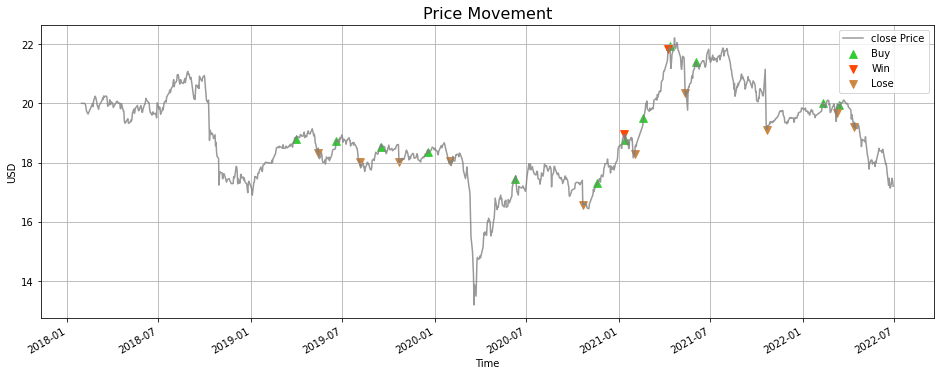

In [205]:
# 實際交易位置
print('buy:{}'.format(buy))
print('win:{}'.format(sell_win))
print('lose:{}'.format(sell_lose))
fig, ax = plt.subplots(figsize = (16,6))

df['close'].plot(label = 'close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(df['close'].iloc[buy].index, df['close'].iloc[buy],c = 'limegreen', label = 'Buy', marker='^', s=60)
plt.scatter(df['close'].iloc[sell_win].index, df['close'].iloc[sell_win],c = 'orangered', label = 'Win', marker='v', s=60)
plt.scatter(df['close'].iloc[sell_lose].index, df['close'].iloc[sell_lose],c = 'peru', label = 'Lose', marker='v', s=60)
# plt.scatter(df['close'].iloc[buy2].index, df['close'].iloc[buy2],c = 'y', label = 'Buy2', marker='^', s=60)
# plt.scatter(df['close'].iloc[sell2].index, df['close'].iloc[sell2],c = 'b', label = 'Sell2', marker='v', s=60)

plt.legend()
plt.ylabel('USD')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16);

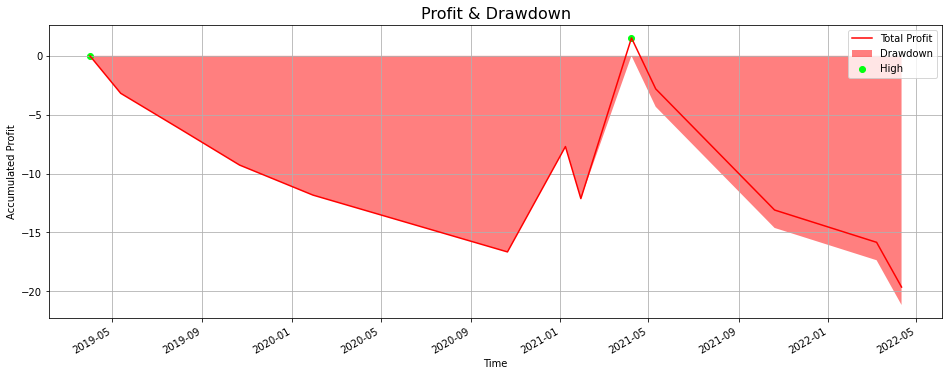

In [206]:
equity['equity'] = equity['profit'] + fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()

fig, ax = plt.subplots(figsize = (16,6))

high_index = equity[equity['profit'].cummax() == equity['profit']].index
equity['profit'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['profit'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);


## for all

In [221]:
# 新策略
symbol = '0050.TW'
print(f'---loading: {symbol}---')
data = yf.Ticker(symbol)
df = data.history(period='D', start='2008-1-1', end='2022-6-30')
df = df.drop(columns = ['Dividends', 'Stock Splits'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['EMA'] = abstract.EMA(df, timeperiod = 200)
df['MACD'] = abstract.MACD(df, fastperiod=17, slowperiod=38, signalperiod=9)['macd']
df['SAR'] = abstract.SAR(df)

fund = 100 #初始有100元本金
money = 100 #每次投入100元
feeRate = 0.003
length = 40 # 均線長度
stdTimes = 2 # 標準差倍數
rule = '1H' # hour


first = 0 ##除了第一筆之外，只紀錄出場的時間點
BS = None ##紀錄現在的狀態是做多還做空
stopEarn = 0
stopLoss = 0

#--------# 記錄買入、賣出時間點
buy = []
sell = []
sellshort = []
buytocover = []
# stopLoss = []
#--------# 
timeList = [] 
profit_list = [0]
profit_fee_list = [0]


for i in range(len(df)):

    if i == len(df)-1: # last trading day
        break
     
      # buy                                       # BS: position, B: buy, S: sell
    if df['close'][i] > df['EMA'][i] and df['MACD'][i] > 0 and df['close'][i] > df['SAR'][i] and BS == None:
        temp = df['open'][i+1] # 要加一 當看到訊號後的進場價
        tempSize = money / temp # 計算交易單位
        BS = 'B' # 做多
        t = i+1 
        buy.append(t)
        stopLoss = df['SAR'][i]
        stopEarn = df['close'][i] + ((df['close'][i] - df['SAR'][i]) * 2)
        # stopLoss.append(df['close'][i] - df['SAR'][i])

        
        if first == 0:
            timeList.append(df.index[i+1])
            first = 1
        continue

      # try 'buy' first 
      # sellshort
    # if df['close'][i] < df['EMA'][i] and df['MACD'][i] < 0 and df['close'][i] < df['SAR'][i] and BS == None:
    #     temp = df['open'][i+1]
    #     tempSize = money / temp
    #     BS = 'S'
    #     t = i+1
    #     sellshort.append(t)
        

    #     if first == 0:
    #         timeList.append(df.index[i+1])
    #         first = 1
    #     continue
        
      # buy停利
    if df['close'][i] > stopEarn and BS == 'B':
        profit = tempSize * (df['open'][i+1] - temp) # temp : 進場價
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue

      # buy停損
    if df['close'][i] < stopLoss and BS == 'B':
        profit = tempSize * (df['open'][i+1] - temp) # temp : 進場價
        profit_fee = profit - money*feeRate - (money+profit)*feeRate
        profit_fee_list.append(profit_fee)
        profit_list.append(profit)
        sell.append(i+1)
        timeList.append(df.index[i])
        BS=None
        continue

       # buy to cover
    # if (df['close'][i] >= df['ma'][i] or i == len(df)-2) and BS == 'S':
    #     profit = tempSize * (temp - df['open'][i+1])
    #     profit_fee = profit - money*feeRate - (money+profit)*feeRate
    #     profit_fee_list.append(profit_fee)
    #     profit_list.append(profit)
    #     buytocover.append(i+1)
    #     timeList.append(df.index[i])
    #     BS=None
    #     continue
    
    # 可加停利停損在這裡：if......
    
# equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=timeList)

equity = pd.DataFrame({'0050.TW':profit_list}, index=timeList)

########-------------------------------------------------------------#########

symbol_list = ['0051.TW', '0052.TW', '0053.TW', '0055.TW', '0056.TW', '006203.TW', '006204.TW', '006208.TW', 
               '00690.TW', '00692.TW', '00701.TW', '00712.TW', '00713.TW', '00714.TW', '00717.TW',
               '00728.TW', '00730.TW', '00731.TW', '00733.TW', '00735.TW']

for j in range(len(symbol_list)):
  symbol = symbol_list[j]

  print(f'---loading: {symbol}---')

    
  data = yf.Ticker(symbol)
  df = data.history(period='D', start='2008-1-1', end='2022-6-30')
  df = df.drop(columns = ['Dividends', 'Stock Splits'])
  df.columns = ['open', 'high', 'low', 'close', 'volume']
  df['EMA'] = abstract.EMA(df, timeperiod = 200)
  df['MACD'] = abstract.MACD(df, fastperiod=17, slowperiod=38, signalperiod=9)['macd']
  df['SAR'] = abstract.SAR(df)

  fund = 100 #初始有100元本金
  money = 100 #每次投入100元
  feeRate = 0.003
  length = 40 # 均線長度
  stdTimes = 2 # 標準差倍數
  rule = '1H' # hour


  first = 0 ##除了第一筆之外，只紀錄出場的時間點
  BS = None ##紀錄現在的狀態是做多還做空
  stopEarn = 0
  stopLoss = 0

  #--------# 記錄買入、賣出時間點
  buy = []
  sell = []
  sellshort = []
  buytocover = []
  # stopLoss = []
  #--------# 
  timeList = [] 
  profit_list = [0]
  profit_fee_list = [0]


  for i in range(len(df)):

      if i == len(df)-1: # last trading day
          break
      
        # buy                                       # BS: position, B: buy, S: sell
      if df['close'][i] > df['EMA'][i] and df['MACD'][i] > 0 and df['close'][i] > df['SAR'][i] and BS == None:
          temp = df['open'][i+1] # 要加一 當看到訊號後的進場價
          tempSize = money / temp # 計算交易單位
          BS = 'B' # 做多
          t = i+1 
          buy.append(t)
          stopLoss = df['SAR'][i]
          stopEarn = df['close'][i] + ((df['close'][i] - df['SAR'][i]) * 2)
          # stopLoss.append(df['close'][i] - df['SAR'][i])

          
          if first == 0:
              timeList.append(df.index[i+1])
              first = 1
          continue

        # try 'buy' first 
        # sellshort
      # if df['close'][i] < df['EMA'][i] and df['MACD'][i] < 0 and df['close'][i] < df['SAR'][i] and BS == None:
      #     temp = df['open'][i+1]
      #     tempSize = money / temp
      #     BS = 'S'
      #     t = i+1
      #     sellshort.append(t)
          

      #     if first == 0:
      #         timeList.append(df.index[i+1])
      #         first = 1
      #     continue
          
        # buy停利
      if df['close'][i] > stopEarn and BS == 'B':
          profit = tempSize * (df['open'][i+1] - temp) # temp : 進場價
          profit_fee = profit - money*feeRate - (money+profit)*feeRate
          profit_fee_list.append(profit_fee)
          profit_list.append(profit)
          sell.append(i+1)
          timeList.append(df.index[i])
          BS=None
          continue

        # buy停損
      if df['close'][i] < stopLoss and BS == 'B':
          profit = tempSize * (df['open'][i+1] - temp) # temp : 進場價
          profit_fee = profit - money*feeRate - (money+profit)*feeRate
          profit_fee_list.append(profit_fee)
          profit_list.append(profit)
          sell.append(i+1)
          timeList.append(df.index[i])
          BS=None
          continue

        # buy to cover
      # if (df['close'][i] >= df['ma'][i] or i == len(df)-2) and BS == 'S':
      #     profit = tempSize * (temp - df['open'][i+1])
      #     profit_fee = profit - money*feeRate - (money+profit)*feeRate
      #     profit_fee_list.append(profit_fee)
      #     profit_list.append(profit)
      #     buytocover.append(i+1)
      #     timeList.append(df.index[i])
      #     BS=None
      #     continue
      
      # 可加停利停損在這裡：if......
      
  # equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=timeList)

  pp = pd.DataFrame({'{}'.format(symbol_list[j]):profit_list}, index=timeList)
  equity = pd.concat([equity,pp], join='outer', axis=1)

equity

---loading: 0050.TW---
---loading: 0051.TW---
---loading: 0052.TW---


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:166: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:197: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: RuntimeWarning: invalid value encountered in double_scalars


---loading: 0053.TW---
---loading: 0055.TW---
---loading: 0056.TW---
---loading: 006203.TW---
---loading: 006204.TW---
---loading: 006208.TW---
---loading: 00690.TW---
---loading: 00692.TW---
---loading: 00701.TW---
---loading: 00712.TW---
---loading: 00713.TW---
---loading: 00714.TW---
---loading: 00717.TW---
---loading: 00728.TW---
---loading: 00730.TW---
---loading: 00731.TW---
---loading: 00733.TW---
---loading: 00735.TW---


,0050.TW,0051.TW,0052.TW,0053.TW,0055.TW,0056.TW,006203.TW,006204.TW,006208.TW,00690.TW,...,00701.TW,00712.TW,00713.TW,00714.TW,00717.TW,00728.TW,00730.TW,00731.TW,00733.TW,00735.TW
2009-03-26,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-03-27,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-10,NaN,0.0,NaN,NaN,NaN,0.00000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-17,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-05-11,NaN,NaN,NaN,17.142857,NaN,13.31445,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.816609,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-5.650559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-10,NaN,NaN,NaN,NaN,-7.427261,NaN,NaN,NaN,NaN,-9.936191,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.781764,NaN,NaN


In [222]:
equity.fillna(0)
df_ATC = equity.sum(axis = 0)
print(df_ATC, f'mean : {df_ATC.mean()}')

0050.TW      106.610815
0051.TW       41.907876
0052.TW      109.785855
0053.TW       31.572258
0055.TW       75.083633
0056.TW       20.960014
006203.TW     38.021283
006204.TW     36.857456
006208.TW     73.891676
00690.TW      28.406243
00692.TW      35.916444
00701.TW      -1.172198
00712.TW      -4.419731
00713.TW      24.921570
00714.TW      -1.523769
00717.TW      -3.741455
00728.TW      23.203562
00730.TW     -15.926135
00731.TW       4.651943
00733.TW      63.862516
00735.TW      42.565794
dtype: float64 mean : 34.830268968622306


# Optimization

* 進場時間

df_in = df[:'2020-01']

df_out = df['2020-02':]

## 濾網：除息日日期

In [ ]:
opt_list = []

symbol = '0050.TW'
data = yf.Ticker(symbol)
df = data.history(period='D', start='2008-1-1', end='2022-6-30')
df = df.drop(columns = ['Dividends', 'Stock Splits'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
Yield = pd.read_csv(path + '/yield.csv')
Yield = Yield.set_index(pd.to_datetime(Yield['date']))
Yield = Yield.drop('date', axis = 1)
df = pd.concat([df,Yield], join='outer', axis=1)
df_in = df[:'2020-01']

# initial setting

fund = 100 #初始有100元本金
money = 100 #每次投入
feeRate = 0.003 #手續費

for In in range(27, 31):
  for Out in range(3, 8):
    
    print('----------')
    print(f'In: {In}')
    print(f'Out: {Out}')
  
    

    # 主要策略

    profit_list = []
    price = []
    buy = []
    sell = []
    open_price = []
    position = "A"
    timeList = []

    for i in range(len(df_in)):

        if i == len(df_in)-1:
          break
        
        if df_in['0050'][i] > 0 and df_in['close'][i] > 0: # 除息日
            tempSize = money / df_in['close'][i-In] # 前 15 天進場
            buy.append(i-In)
      
            profit = tempSize * (df_in['close'][i-Out] - df_in['close'][i-In]) # 前 5 天出場並計算報酬
            sell.append(i-Out)
            profit_list.append(profit)
            timeList.append(df_in.index[i]) 


        else:
          profit_list.append(0)
          timeList.append(df_in.index[i])

    equity = pd.DataFrame({'0050.TW':np.cumsum(profit_list)}, index=timeList)
      
    ########-------------------------------------------------------------#########

    symbol_list = ['0051.TW', '0052.TW', '0053.TW', '0055.TW', '0056.TW', '006203.TW', '006204.TW', '006208.TW', 
                  '00690.TW', '00692.TW', '00701.TW', '00712.TW', '00713.TW', '00714.TW', '00717.TW',
                  '00728.TW', '00730.TW', '00731.TW', '00733.TW', '00735.TW']

    for j in range(len(symbol_list)):
      symbol = symbol_list[j]

      data = yf.Ticker(symbol)
      df = data.history(period='D', start='2008-1-1', end='2022-6-30')
      df = df.drop(columns = ['Dividends', 'Stock Splits'])
      df.columns = ['open', 'high', 'low', 'close', 'volume']
      Yield = pd.read_csv(path + '/yield.csv')
      Yield = Yield.set_index(pd.to_datetime(Yield['date']))
      Yield = Yield.drop('date', axis = 1)
      df = pd.concat([df,Yield], join='outer', axis=1)
      df_in = df[:'2020-01']

      # initial setting

      fund = 100 #初始有100元本金
      money = 100 #每次投入
      feeRate = 0.003 #手續費

      # 主要策略

      profit_list = []
      price = []
      buy = []
      sell = []
      open_price = []
      position = "A"
      timeList = []

      for i in range(len(df_in)):

          if i == len(df_in)-1:
            break
          
          if df_in.iloc[:,j+6][i] > 0 and df_in['close'][i] > 0: # 除息日
              tempSize = money / df_in['close'][i-In] # 前 In 天進場
              buy.append(i-In)
        
              profit = tempSize * (df_in['close'][i-Out] - df_in['close'][i-In]) # 前 Out 天出場並計算報酬
              sell.append(i-Out)
              profit_list.append(profit)
              timeList.append(df_in.index[i]) 


          else:
            profit_list.append(0)
            timeList.append(df_in.index[i])

      pp = pd.DataFrame({'{}'.format(symbol_list[j]):np.cumsum(profit_list)}, index=timeList)
      equity = pd.concat([equity,pp], join='outer', axis=1)

    ret = equity.iloc[-1].mean()
    opt_list.append([In, Out, ret])

----------
In: 27
Out: 3
----------
In: 27
Out: 4
----------
In: 27
Out: 5
----------
In: 27
Out: 6
----------
In: 27
Out: 7
----------
In: 28
Out: 3
----------
In: 28
Out: 4
----------
In: 28
Out: 5
----------
In: 28
Out: 6
----------
In: 28
Out: 7
----------
In: 29
Out: 3
----------
In: 29
Out: 4
----------
In: 29
Out: 5
----------
In: 29
Out: 6
----------
In: 29
Out: 7
----------
In: 30
Out: 3
----------
In: 30
Out: 4
----------
In: 30
Out: 5
----------
In: 30
Out: 6
----------
In: 30
Out: 7


In [ ]:
optResult = pd.DataFrame(opt_list, columns=['In','Out','return'])
optResult.sort_values('return', ascending = False)

,In,Out,return
0,27,3,5.107776
6,28,4,4.499667
1,27,4,4.324314
11,29,4,4.296884
5,28,3,4.022442
7,28,5,3.897235
16,30,4,3.841649
10,29,3,3.675508
2,27,5,3.502788
12,29,5,3.437744


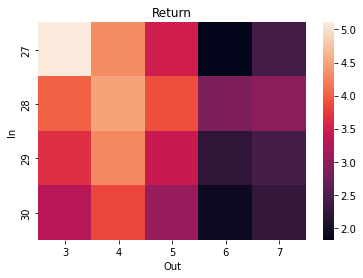

In [ ]:
pic = optResult.pivot('In', 'Out', 'return') # 先整理資料格式
sns.heatmap(data = pic).set(title='Return');

## 濾網：MACD
* result : fast = 17, slow = 38

In [218]:
# 新策略
opt_list = []


for fast in range(5, 20, 2):
  for slow in range(20, 41, 2):

    symbol = '0050.TW'
    data = yf.Ticker(symbol)
    df = data.history(period='D', start='2008-1-1', end='2022-6-30')
    df = df.drop(columns = ['Dividends', 'Stock Splits'])
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    fund = 100 #初始有100元本金
    money = 100 #每次投入100元
    feeRate = 0.003
    length = 40 # 均線長度
    stdTimes = 2 # 標準差倍數
    rule = '1H' # hour


    first = 0 ##除了第一筆之外，只紀錄出場的時間點
    BS = None ##紀錄現在的狀態是做多還做空
    stopEarn = 0
    stopLoss = 0

    print('#####----------#####')
    print(f'fast: {fast}')
    print(f'slow: {slow}')

    print(f'---loading: {symbol}---')

    df['EMA'] = abstract.EMA(df, timeperiod = 200)
    df['MACD'] = abstract.MACD(df, fastperiod=fast, slowperiod=slow, signalperiod=9)['macd']
    df['SAR'] = abstract.SAR(df)

    #--------# 記錄買入、賣出時間點
    buy = []
    sell = []
    sellshort = []
    buytocover = []
    # stopLoss = []
    #--------# 
    timeList = [] 
    profit_list = [0]
    profit_fee_list = [0]


    for i in range(len(df)):

        if i == len(df)-1: # last trading day
            break
        
          # buy                                       # BS: position, B: buy, S: sell
        if df['close'][i] > df['EMA'][i] and df['MACD'][i] > 0 and df['close'][i] > df['SAR'][i] and BS == None:
            temp = df['open'][i+1] # 要加一 當看到訊號後的進場價
            tempSize = money / temp # 計算交易單位
            BS = 'B' # 做多
            t = i+1 
            buy.append(t)
            stopLoss = df['SAR'][i]
            stopEarn = df['close'][i] + ((df['close'][i] - df['SAR'][i]) * 2)
            # stopLoss.append(df['close'][i] - df['SAR'][i])

            
            if first == 0:
                timeList.append(df.index[i+1])
                first = 1
            continue

          # try 'buy' first 
          # sellshort
        # if df['close'][i] < df['EMA'][i] and df['MACD'][i] < 0 and df['close'][i] < df['SAR'][i] and BS == None:
        #     temp = df['open'][i+1]
        #     tempSize = money / temp
        #     BS = 'S'
        #     t = i+1
        #     sellshort.append(t)
            

        #     if first == 0:
        #         timeList.append(df.index[i+1])
        #         first = 1
        #     continue
            
          # buy停利
        if df['close'][i] > stopEarn and BS == 'B':
            profit = tempSize * (df['open'][i+1] - temp) # temp : 進場價
            profit_fee = profit - money*feeRate - (money+profit)*feeRate
            profit_fee_list.append(profit_fee)
            profit_list.append(profit)
            sell.append(i+1)
            timeList.append(df.index[i])
            BS=None
            continue

          # buy停損
        if df['close'][i] < stopLoss and BS == 'B':
            profit = tempSize * (df['open'][i+1] - temp) # temp : 進場價
            profit_fee = profit - money*feeRate - (money+profit)*feeRate
            profit_fee_list.append(profit_fee)
            profit_list.append(profit)
            sell.append(i+1)
            timeList.append(df.index[i])
            BS=None
            continue

          # buy to cover
        # if (df['close'][i] >= df['ma'][i] or i == len(df)-2) and BS == 'S':
        #     profit = tempSize * (temp - df['open'][i+1])
        #     profit_fee = profit - money*feeRate - (money+profit)*feeRate
        #     profit_fee_list.append(profit_fee)
        #     profit_list.append(profit)
        #     buytocover.append(i+1)
        #     timeList.append(df.index[i])
        #     BS=None
        #     continue
        
        # 可加停利停損在這裡：if......
        
    # equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=timeList)

    equity = pd.DataFrame({'0050.TW':profit_list}, index=timeList)

    ########-------------------------------------------------------------#########

    symbol_list = ['0051.TW', '0052.TW', '0053.TW', '0055.TW', '0056.TW', '006203.TW', '006204.TW', '006208.TW', 
                  '00690.TW', '00692.TW', '00701.TW', '00712.TW', '00713.TW', '00714.TW', '00717.TW',
                  '00728.TW', '00730.TW', '00731.TW', '00733.TW', '00735.TW']

    for j in range(len(symbol_list)):
      symbol = symbol_list[j]

      print(f'---loading: {symbol}---')

        
      data = yf.Ticker(symbol)
      df = data.history(period='D', start='2008-1-1', end='2022-6-30')
      df = df.drop(columns = ['Dividends', 'Stock Splits'])
      df.columns = ['open', 'high', 'low', 'close', 'volume']
      df['EMA'] = abstract.EMA(df, timeperiod = 200)
      df['MACD'] = abstract.MACD(df, fastperiod=fast, slowperiod=slow, signalperiod=9)['macd']
      df['SAR'] = abstract.SAR(df)

      fund = 100 #初始有100元本金
      money = 100 #每次投入100元
      feeRate = 0.003
      length = 40 # 均線長度
      stdTimes = 2 # 標準差倍數
      rule = '1H' # hour


      first = 0 ##除了第一筆之外，只紀錄出場的時間點
      BS = None ##紀錄現在的狀態是做多還做空
      stopEarn = 0
      stopLoss = 0

      #--------# 記錄買入、賣出時間點
      buy = []
      sell = []
      sellshort = []
      buytocover = []
      # stopLoss = []
      #--------# 
      timeList = [] 
      profit_list = [0]
      profit_fee_list = [0]


      for i in range(len(df)):

          if i == len(df)-1: # last trading day
              break
          
            # buy                                       # BS: position, B: buy, S: sell
          if df['close'][i] > df['EMA'][i] and df['MACD'][i] > 0 and df['close'][i] > df['SAR'][i] and BS == None:
              temp = df['open'][i+1] # 要加一 當看到訊號後的進場價
              tempSize = money / temp # 計算交易單位
              BS = 'B' # 做多
              t = i+1 
              buy.append(t)
              stopLoss = df['SAR'][i]
              stopEarn = df['close'][i] + ((df['close'][i] - df['SAR'][i]) * 2)
              # stopLoss.append(df['close'][i] - df['SAR'][i])

              
              if first == 0:
                  timeList.append(df.index[i+1])
                  first = 1
              continue

            # try 'buy' first 
            # sellshort
          # if df['close'][i] < df['EMA'][i] and df['MACD'][i] < 0 and df['close'][i] < df['SAR'][i] and BS == None:
          #     temp = df['open'][i+1]
          #     tempSize = money / temp
          #     BS = 'S'
          #     t = i+1
          #     sellshort.append(t)
              

          #     if first == 0:
          #         timeList.append(df.index[i+1])
          #         first = 1
          #     continue
              
            # buy停利
          if df['close'][i] > stopEarn and BS == 'B':
              profit = tempSize * (df['open'][i+1] - temp) # temp : 進場價
              profit_fee = profit - money*feeRate - (money+profit)*feeRate
              profit_fee_list.append(profit_fee)
              profit_list.append(profit)
              sell.append(i+1)
              timeList.append(df.index[i])
              BS=None
              continue

            # buy停損
          if df['close'][i] < stopLoss and BS == 'B':
              profit = tempSize * (df['open'][i+1] - temp) # temp : 進場價
              profit_fee = profit - money*feeRate - (money+profit)*feeRate
              profit_fee_list.append(profit_fee)
              profit_list.append(profit)
              sell.append(i+1)
              timeList.append(df.index[i])
              BS=None
              continue

            # buy to cover
          # if (df['close'][i] >= df['ma'][i] or i == len(df)-2) and BS == 'S':
          #     profit = tempSize * (temp - df['open'][i+1])
          #     profit_fee = profit - money*feeRate - (money+profit)*feeRate
          #     profit_fee_list.append(profit_fee)
          #     profit_list.append(profit)
          #     buytocover.append(i+1)
          #     timeList.append(df.index[i])
          #     BS=None
          #     continue
          
          # 可加停利停損在這裡：if......
          
      # equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=timeList)

      pp = pd.DataFrame({'{}'.format(symbol_list[j]):profit_list}, index=timeList)
      equity = pd.concat([equity,pp], join='outer', axis=1)

    equity.fillna(0)
    df_ATC = equity.sum(axis = 0)
    ret = df_ATC.mean()
    opt_list.append([fast, slow, ret])


#####----------#####
fast: 5
slow: 20
---loading: 0050.TW---
---loading: 0051.TW---
---loading: 0052.TW---


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:177: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:219: RuntimeWarning: invalid value encountered in double_scalars


---loading: 0053.TW---
---loading: 0055.TW---
---loading: 0056.TW---
---loading: 006203.TW---
---loading: 006204.TW---
---loading: 006208.TW---
---loading: 00690.TW---
---loading: 00692.TW---
---loading: 00701.TW---
---loading: 00712.TW---
---loading: 00713.TW---
---loading: 00714.TW---
---loading: 00717.TW---
---loading: 00728.TW---
---loading: 00730.TW---
---loading: 00731.TW---
---loading: 00733.TW---
---loading: 00735.TW---
#####----------#####
fast: 5
slow: 22
---loading: 0050.TW---
---loading: 0051.TW---
---loading: 0052.TW---
---loading: 0053.TW---
---loading: 0055.TW---
---loading: 0056.TW---
---loading: 006203.TW---
---loading: 006204.TW---
---loading: 006208.TW---
---loading: 00690.TW---
---loading: 00692.TW---
---loading: 00701.TW---
---loading: 00712.TW---
---loading: 00713.TW---
---loading: 00714.TW---
---loading: 00717.TW---
---loading: 00728.TW---
---loading: 00730.TW---
---loading: 00731.TW---
---loading: 00733.TW---
---loading: 00735.TW---
#####----------#####
fast: 5


In [219]:
optResult = pd.DataFrame(opt_list, columns=['fast','slow','return'])
optResult.sort_values('return', ascending = False)

,fast,slow,return
75,17,38,47.099416
73,17,34,44.880240
76,17,40,44.307358
74,17,36,42.759658
66,17,20,40.561975
...,...,...,...
83,19,32,30.687294
26,9,28,30.341092
35,11,24,30.123221
9,5,38,30.023150


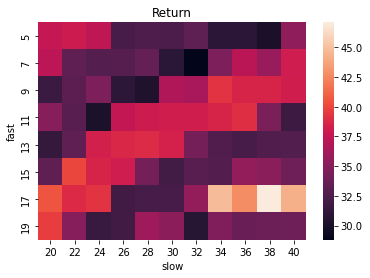

In [220]:
pic = optResult.pivot('fast', 'slow', 'return') # 先整理資料格式
sns.heatmap(data = pic).set(title='Return');

# Combine two strategies

## for single symbol

In [128]:


startday = '2015-1-1'
endday = '2022-1-1'

symbol = '0053.TW'
data = yf.Ticker(symbol)
df = data.history(period='D', start = startday, end = endday)
df = df.drop(columns = ['Dividends', 'Stock Splits'])
df.columns = ['open', 'high', 'low', 'close', 'volume']

df['EMA'] = abstract.EMA(df, timeperiod = 200)
df['MACD'] = abstract.MACD(df, fastperiod=9, slowperiod=24, signalperiod=9)['macd']
df['SAR'] = abstract.SAR(df)

Yield = pd.read_csv(path + '/yield.csv')
Yield = Yield.set_index(pd.to_datetime(Yield['date']))
Yield = Yield.drop('date', axis = 1)
df = pd.concat([df,Yield], join='outer', axis=1)

# initial setting

fund = 100 #初始有100元本金
money = 100 #每次投入
feeRate = 0.003 #手續費

# 主要策略

profit_list = []
price = [] # 除息日
buy = []
sell_win = []
sell_lose = []
sell_close = []
timeList = []
first = 0 ##除了第一筆之外，只紀錄出場的時間點
BS = None ##紀錄現在的狀態是做多還做空
stopEarn = 0
stopLoss = 0

# 除息日期間設定
In = 30 
Out = 5

for i in range(len(df)):

    if i == len(df)-1:
      break
    
    if df['0053'][i] > 0 and df['close'][i] > 0: # 除息日
      price.append(i)

      for j in range(i-In, i-Out+1):

        if df['close'][j] > df['EMA'][j] and df['MACD'][j] > 0 and df['close'][j] > df['SAR'][j] and BS == None:

            temp = df['open'][j+1] # 要加一 當看到訊號後的進場價
            tempSize = money / temp # 計算交易單位
            BS = 'B' # 做多
            buy.append(j+1)
            stopLoss = df['SAR'][j]
            stopEarn = df['close'][j] + ((df['close'][j] - df['SAR'][j]))
            continue

           # buy停利
        if df['close'][j] > stopEarn and BS == 'B':
            profit = tempSize * (df['open'][j+1] - temp) # temp : 進場價
            # profit_fee = profit - money*feeRate - (money+profit)*feeRate
            # profit_fee_list.append(profit_fee)
            profit_list.append(profit)
            timeList.append(df.index[j+1])
            sell_win.append(j+1)
            BS=None
            

          # buy停損
        if df['close'][j] < stopLoss and BS == 'B':
            profit = tempSize * (df['open'][j+1] - temp) # temp : 進場價
            # profit_fee = profit - money*feeRate - (money+profit)*feeRate
            # profit_fee_list.append(profit_fee)
            profit_list.append(profit)
            timeList.append(df.index[j+1])
            sell_lose.append(j+1)
            BS=None
            

          # 最後一天平倉
        if j == (i-Out) and BS == 'B': 
            profit = tempSize * (df['open'][j+1] - temp) # temp : 進場價
            # profit_fee = profit - money*feeRate - (money+profit)*feeRate
            # profit_fee_list.append(profit_fee)
            profit_list.append(profit)
            timeList.append(df.index[j+1])
            sell_close.append(j+1)
            BS=None

equity = pd.DataFrame({'0050.TW':np.cumsum(profit_list)}, index=timeList)
equity

,0050.TW
2016-10-18,-0.826710
2016-11-04,-7.470061
2017-11-17,-5.746843
2019-10-15,-4.366638
2019-11-05,1.070352
2019-11-18,0.396297
2020-11-16,2.349422
2021-11-10,6.563121
2021-11-15,8.402709


buy:[1736, 1743, 1983, 2471, 2473, 2488, 2715, 2969, 2981]
win:[2472, 2487, 2980]
lose:[1739, 1752]
close the position:[2008, 2496, 2739, 2983]
date of yld:[1518, 1765, 2012, 2258, 2500, 2743, 2987]


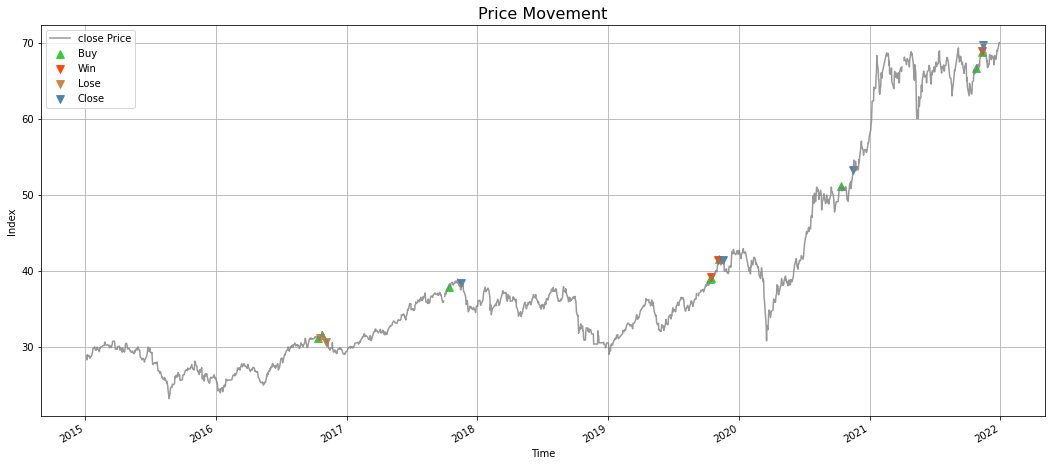

In [129]:
# 實際交易位置
print('buy:{}'.format(buy))
print('win:{}'.format(sell_win))
print('lose:{}'.format(sell_lose))
print('close the position:{}'.format(sell_close))
print('date of yld:{}'.format(price))
fig, ax = plt.subplots(figsize = (18,8))

df['close'].plot(label = 'close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(df['close'].iloc[buy].index, df['close'].iloc[buy],c = 'limegreen', label = 'Buy', marker='^', s=60)
plt.scatter(df['close'].iloc[sell_win].index, df['close'].iloc[sell_win],c = 'orangered', label = 'Win', marker='v', s=60)
plt.scatter(df['close'].iloc[sell_lose].index, df['close'].iloc[sell_lose],c = 'peru', label = 'Lose', marker='v', s=60)
plt.scatter(df['close'].iloc[sell_close].index, df['close'].iloc[sell_close],c = 'steelblue', label = 'Close', marker='v', s=60)

# plt.scatter(df['close'].iloc[buy2].index, df['close'].iloc[buy2],c = 'y', label = 'Buy2', marker='^', s=60)
# plt.scatter(df['close'].iloc[sell2].index, df['close'].iloc[sell2],c = 'b', label = 'Sell2', marker='v', s=60)

plt.legend()
plt.ylabel('Index')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16);

## for all

In [138]:
startday = '2008-1-1'
endday = '2022-1-1'

symbol = '0050.TW'
data = yf.Ticker(symbol)
df = data.history(period='D', start = startday, end = endday)
df = df.drop(columns = ['Dividends', 'Stock Splits'])
df.columns = ['open', 'high', 'low', 'close', 'volume']

df['EMA'] = abstract.EMA(df, timeperiod = 200)
df['MACD'] = abstract.MACD(df, fastperiod=17, slowperiod=38, signalperiod=9)['macd']
df['SAR'] = abstract.SAR(df)

Yield = pd.read_csv(path + '/yield.csv')
Yield = Yield.set_index(pd.to_datetime(Yield['date']))
Yield = Yield.drop('date', axis = 1)
df = pd.concat([df,Yield], join='outer', axis=1)

# initial setting

fund = 100 #初始有100元本金
money = 100 #每次投入
feeRate = 0.003 #手續費

# 主要策略

profit_list = []
price = [] # 除息日
buy = []
sell = []
timeList = []
first = 0 ##除了第一筆之外，只紀錄出場的時間點
BS = None ##紀錄現在的狀態是做多還做空
stopEarn = 0
stopLoss = 0

# 除息日期間設定
In = 30 
Out = 5

print(f'---loading: {symbol}---')

for i in range(len(df)):

    if i == len(df)-1:
      break
    
    if df['0050'][i] > 0 and df['close'][i] > 0: # 除息日
      price.append(i)

      for j in range(i-In, i-Out+1):

        if df['close'][j] > df['EMA'][j] and df['MACD'][j] > 0 and df['close'][j] > df['SAR'][j] and BS == None:

            temp = df['open'][j+1] # 要加一 當看到訊號後的進場價
            tempSize = money / temp # 計算交易單位
            BS = 'B' # 做多
            buy.append(j+1)
            stopLoss = df['SAR'][j]
            stopEarn = df['close'][j] + ((df['close'][j] - df['SAR'][j]))
            continue

           # buy停利
        if df['close'][j] > stopEarn and BS == 'B':
            profit = tempSize * (df['open'][j+1] - temp) # temp : 進場價
            # profit_fee = profit - money*feeRate - (money+profit)*feeRate
            # profit_fee_list.append(profit_fee)
            profit_list.append(profit)
            timeList.append(df.index[j+1])
            sell.append(j+1)
            BS=None
            

          # buy停損
        if df['close'][j] < stopLoss and BS == 'B':
            profit = tempSize * (df['open'][j+1] - temp) # temp : 進場價
            # profit_fee = profit - money*feeRate - (money+profit)*feeRate
            # profit_fee_list.append(profit_fee)
            profit_list.append(profit)
            timeList.append(df.index[j+1])
            sell.append(j+1)
            BS=None
            

          # 最後一天平倉
        if j == (i-Out) and BS == 'B': 
            profit = tempSize * (df['open'][j+1] - temp) # temp : 進場價
            # profit_fee = profit - money*feeRate - (money+profit)*feeRate
            # profit_fee_list.append(profit_fee)
            profit_list.append(profit)
            timeList.append(df.index[j+1])
            sell.append(j+1)
            BS=None

equity = pd.DataFrame({'0050.TW':profit_list}, index=timeList)


########-------------------------------------------------------------#########

symbol_list = ['0051.TW', '0052.TW', '0053.TW', '0055.TW', '0056.TW', '006203.TW', '006204.TW', '006208.TW', 
               '00690.TW', '00692.TW', '00701.TW', '00712.TW', '00713.TW', '00714.TW', '00717.TW',
               '00728.TW', '00730.TW', '00731.TW', '00733.TW', '00735.TW']

for k in range(len(symbol_list)):
  symbol = symbol_list[k]

  print(f'---loading: {symbol}---')

  data = yf.Ticker(symbol)
  df = data.history(period='D', start = startday, end = endday)
  df = df.drop(columns = ['Dividends', 'Stock Splits'])
  df.columns = ['open', 'high', 'low', 'close', 'volume']

  df['EMA'] = abstract.EMA(df, timeperiod = 200)
  df['MACD'] = abstract.MACD(df, fastperiod=9, slowperiod=24, signalperiod=9)['macd']
  df['SAR'] = abstract.SAR(df)

  Yield = pd.read_csv(path + '/yield.csv')
  Yield = Yield.set_index(pd.to_datetime(Yield['date']))
  Yield = Yield.drop('date', axis = 1)
  df = pd.concat([df,Yield], join='outer', axis=1)

  # initial setting

  fund = 100 #初始有100元本金
  money = 100 #每次投入
  feeRate = 0.003 #手續費

  # 主要策略

  profit_list = []
  price = [] # 除息日
  buy = []
  sell = []
  timeList = []
  first = 0 ##除了第一筆之外，只紀錄出場的時間點
  BS = None ##紀錄現在的狀態是做多還做空
  stopEarn = 0
  stopLoss = 0

  # # 除息日期間設定
  # In = 30 
  # Out = 5

  for i in range(len(df)):

      if i == len(df)-1:
        break
      
      if df.iloc[:,k+9][i] > 0 and df['close'][i] > 0: # 除息日 df.iloc[:,k+9][i]  df['0050'][i]
        price.append(i)

        for j in range(i-In, i-Out+1):

          if df['close'][j] > df['EMA'][j] and df['MACD'][j] > 0 and df['close'][j] > df['SAR'][j] and BS == None:

              temp = df['open'][j+1] # 要加一 當看到訊號後的進場價
              tempSize = money / temp # 計算交易單位
              BS = 'B' # 做多
              buy.append(j+1)
              stopLoss = df['SAR'][j]
              stopEarn = df['close'][j] + ((df['close'][j] - df['SAR'][j]))
              continue

            # buy停利
          if df['close'][j] > stopEarn and BS == 'B':
              profit = tempSize * (df['open'][j+1] - temp) # temp : 進場價
              # profit_fee = profit - money*feeRate - (money+profit)*feeRate
              # profit_fee_list.append(profit_fee)
              profit_list.append(profit)
              timeList.append(df.index[j+1])
              sell.append(j+1)
              BS=None
              

            # buy停損
          if df['close'][j] < stopLoss and BS == 'B':
              profit = tempSize * (df['open'][j+1] - temp) # temp : 進場價
              # profit_fee = profit - money*feeRate - (money+profit)*feeRate
              # profit_fee_list.append(profit_fee)
              profit_list.append(profit)
              timeList.append(df.index[j+1])
              sell.append(j+1)
              BS=None
              

            # 最後一天平倉
          if j == (i-Out) and BS == 'B': 
              profit = tempSize * (df['open'][j+1] - temp) # temp : 進場價
              # profit_fee = profit - money*feeRate - (money+profit)*feeRate
              # profit_fee_list.append(profit_fee)
              profit_list.append(profit)
              timeList.append(df.index[j+1])
              sell.append(j+1)
              BS=None

  pp = pd.DataFrame({'{}'.format(symbol_list[k]):profit_list}, index=timeList)
  equity = pd.concat([equity,pp], join='outer', axis=1)

equity

---loading: 0050.TW---
---loading: 0051.TW---
---loading: 0052.TW---
---loading: 0053.TW---
---loading: 0055.TW---
---loading: 0056.TW---
---loading: 006203.TW---
---loading: 006204.TW---
---loading: 006208.TW---
---loading: 00690.TW---
---loading: 00692.TW---
---loading: 00701.TW---
---loading: 00712.TW---
---loading: 00713.TW---
---loading: 00714.TW---
---loading: 00717.TW---
---loading: 00728.TW---
---loading: 00730.TW---
---loading: 00731.TW---
---loading: 00733.TW---
---loading: 00735.TW---


,0050.TW,0051.TW,0052.TW,0053.TW,0055.TW,0056.TW,006203.TW,006204.TW,006208.TW,00690.TW,...,00701.TW,00712.TW,00713.TW,00714.TW,00717.TW,00728.TW,00730.TW,00731.TW,00733.TW,00735.TW
2009-11-03,NaN,-6.593407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-11-18,NaN,0.630474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-27,NaN,NaN,4.366812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-16,2.970300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-19,-1.143356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.873563,NaN,NaN
2021-11-15,NaN,2.434930,NaN,1.839588,1.972301,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.640497,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.234582,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-1.862072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [139]:
equity.fillna(0)

df1 = equity.sum(axis = 0)
df1

0050.TW      51.487296
0051.TW      -0.752754
0052.TW       2.143463
0053.TW       0.983892
0055.TW      10.331087
0056.TW      -6.060594
006203.TW    36.252283
006204.TW    -7.948770
006208.TW    31.280696
00690.TW     16.152708
00692.TW     20.626377
00701.TW      6.972815
00712.TW      1.040456
00713.TW      9.565621
00714.TW     -3.397444
00717.TW      2.755290
00728.TW     14.967965
00730.TW     -0.698555
00731.TW      9.393078
00733.TW      6.427241
00735.TW     19.782595
dtype: float64

In [136]:
equity.fillna(0)

df2 = equity.sum(axis = 0)
df2

0050.TW      51.487296
0051.TW      51.301344
0052.TW      52.808017
0053.TW      58.231733
0055.TW      18.531067
0056.TW      31.042904
006203.TW    45.421342
006204.TW    42.256180
006208.TW    34.970317
00690.TW     20.235949
00692.TW     23.254991
00701.TW     12.401219
00712.TW    -11.552818
00713.TW      8.725597
00714.TW    -11.876046
00717.TW    -13.030083
00728.TW     28.782082
00730.TW      7.586733
00731.TW      9.425666
00733.TW     27.212017
00735.TW     28.368316
dtype: float64

In [145]:
print(f'mean return with yld date = each etf : {df1.mean()}')
print(f'mean return with yld date = 0050 : {df2.mean()}')

mean return with yld date = each etf : 10.538321284993922
mean return with yld date = 0050 : 24.551610504783525


# End